###### The latest version of this IPython notebook is available at [http://github.com/jckantor/ESTM60203](http://github.com/jckantor/ESTM60203)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License (CC BY-NC-SA 4.0)](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Warehouse Fulfullment Operations

This [IPython notebook](http://ipython.org/notebook.html) demonstrates use of the [SimPy](http://simpy.readthedocs.org/en/latest/) to simulate the order fulfillment operations of a hypothetical warehouse.

### Initializations

In [2]:
from IPython.core.display import HTML
HTML(open("styles/custom.css", "r").read())

## Order Fulfillment Model

http://kevingue.wordpress.com/2012/02/13/discrete-time-modeling-for-order-picking/

### Order Processing

The order fulfillment operation is a sequence of eight events

1. Order sent to the fulfillment center.
1. Picker requested for the order.
1. Order picked from the warehouse.
1. Picker released.
1. Inspector requested to review the order prior to shipping.
1. Order reviewed.
1. Reviewer released.
1. Order shipped.

### Order Generator

`orderGenerator` creates a sequence of orders following a Poisson distribution at an average rate 1/T_ORDER. Each order is tagged with a unique name using `itertools.count()`.

### Event Logging

Events are logged and stored in a dictionary attached to an instance of the fulfillment class. The keys are an (orderId,event) tuple with the time stamp stored as the value. The raw data trace can be accessed as the `._data` field, or as a pandas Dataframe in the `.log` field.

### Fulfillment Class

In [3]:
# Global variables
T_ORDER = 10                      # average time between orders (Poisson)
T_PICK = 15                       # mean time to pick order from warehouse (beta)
T_REVIEW = 2                      # mean time to review order prior to shipment (beta)
T_SHIP_MIN = 8; T_SHIP_MAX = 12   # mean time to ship order (uniform)
ALPHA = 2.0; BETA = 5.0           # beta distribution parameters

# Global defaults
T_SIM = 1440               # simulation period
N_PICKER = 2               # number of product pickers
N_REVIEWER = 1             # number of product reviewers

import simpy
import itertools
import random
import pandas as pd

class fulfillment(object):
    def __init__(self, n_picker=N_PICKER, n_reviewer=N_REVIEWER):
        self.env = simpy.Environment()
        self._data = dict()
        self.picker = simpy.Resource(self.env,n_picker)
        self.reviewer = simpy.Resource(self.env,n_reviewer)
        self.env.process(self.orderGenerator())
        
    def writeLog(self,orderId,event):
        self._data[orderId,event] = self.env.now
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,self._data[a,b]] for (a,b) in self._data.keys()])      
        df = df.pivot(index=0,columns=1,values=2).reset_index()
        return df[list(df.columns)[1:]] 
    
    @property
    def stats(self):
        tdelta = pd.DataFrame()
        for c in self.log.columns:
            tdelta[c] = self.log[c] - self.log['Ordered']
        return pd.DataFrame([tdelta.mean(),tdelta.std()],index=['mean','std'])
        
    def order(self,orderId):
        self.writeLog(orderId,'Ordered')
        with self.picker.request() as preq:
            yield preq
            self.writeLog(orderId,'Pick Assigned')
            yield self.env.timeout(T_PICK*((ALPHA+BETA)/ALPHA)*random.betavariate(ALPHA,BETA))
            self.writeLog(orderId,'Picked')
            self.picker.release(preq)
        with self.reviewer.request() as rreq:
            yield rreq
            self.writeLog(orderId,'Review Assigned')
            yield self.env.timeout(T_REVIEW*((ALPHA+BETA)/ALPHA)*random.betavariate(ALPHA,BETA))
            self.writeLog(orderId,'Reviewed')
            self.reviewer.release(rreq)
                
        yield self.env.timeout(random.uniform(T_SHIP_MIN,T_SHIP_MAX))
        self.writeLog(orderId,'Shipped')
                
    def orderGenerator(self):
        for orderId in itertools.count():
            yield self.env.timeout(random.expovariate(1.0/T_ORDER))
            self.env.process(self.order(orderId))
             
    def run(self,t_sim = T_SIM):
        self.env.run(until=t_sim)

### Simulation

Elapsed Time from Order Placement
      Ordered  Pick Assigned     Picked  Review Assigned   Reviewed    Shipped
mean      0.0       0.372984  15.342372        15.684901  17.664159  27.649617
std       0.0       1.717008   8.519451         8.533925   8.601076   8.694360


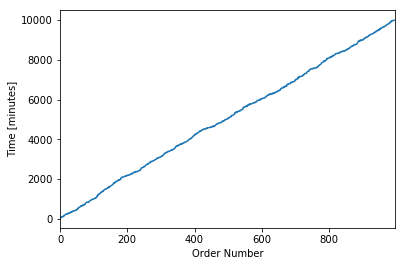

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

# create an order fulfillment instance
w = fulfillment(n_picker = 4, n_reviewer = 1)

# run a simulation for a specified period
w.run(10000)

print("Elapsed Time from Order Placement")
print(w.stats)


# plot log results
w.log['Shipped'].plot()
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')

## Analyzing Results

### Total Processing Time

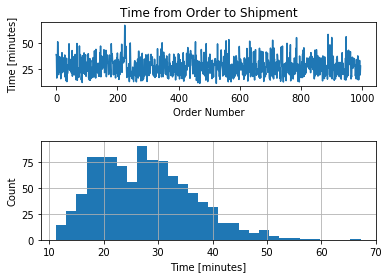

In [26]:
torder = w.log['Shipped'] - w.log['Ordered']
plt.subplot(3,1,1)
plt.plot(torder)
plt.xlabel('Order Number')
plt.ylabel('Time [minutes]')
plt.title('Time from Order to Shipment')

plt.subplot(2,1,2)
torder.hist(bins=30)
plt.xlabel('Time [minutes]')
plt.ylabel('Count')

### Time to Assign Picker

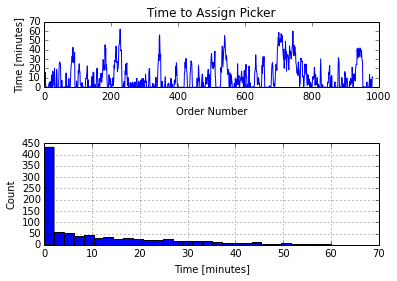

In [5]:
twait = w.log['Pick Assigned'] - w.log['Ordered']
subplot(3,1,1)
plot(twait)
xlabel('Order Number')
ylabel('Time [minutes]')
title('Time to Assign Picker')

subplot(2,1,2)
twait.hist(bins=30)
xlabel('Time [minutes]')
ylabel('Count')

### Time to Pick Order

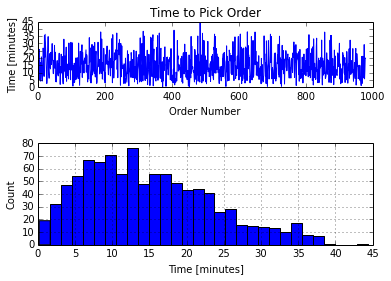

In [6]:
tpick = w.log['Picked'] - w.log['Pick Assigned']
subplot(3,1,1)
plot(tpick)
xlabel('Order Number')
ylabel('Time [minutes]')
title('Time to Pick Order')

subplot(2,1,2)
tpick.hist(bins=30)
xlabel('Time [minutes]')
ylabel('Count')

### Time to Assign Reviewer

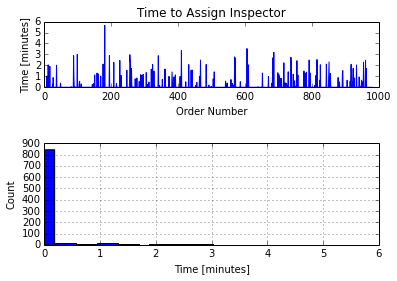

In [7]:
twait = w.log['Review Assigned'] - w.log['Picked']
subplot(3,1,1)
plot(twait)
xlabel('Order Number')
ylabel('Time [minutes]')
title('Time to Assign Inspector')

subplot(2,1,2)
twait.hist(bins=30)
xlabel('Time [minutes]')
ylabel('Count')

### Time to Review Order

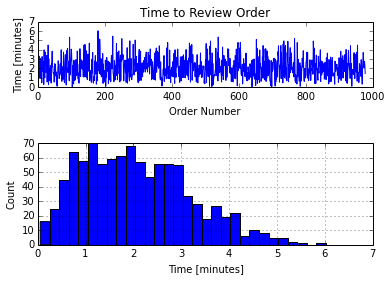

In [8]:
treview = w.log['Reviewed'] - w.log['Review Assigned']
subplot(3,1,1)
plot(treview)
xlabel('Order Number')
ylabel('Time [minutes]')
title('Time to Review Order')

subplot(2,1,2)
treview.hist(bins=30)
xlabel('Time [minutes]')
ylabel('Count')

### Time to Ship

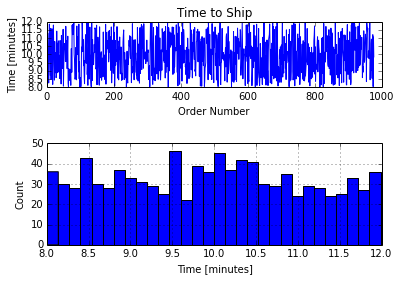

In [9]:
tship = w.log['Shipped'] - w.log['Reviewed']
subplot(3,1,1)
plot(tship)
xlabel('Order Number')
ylabel('Time [minutes]')
title('Time to Ship')

subplot(2,1,2)
tship.hist(bins=30)
xlabel('Time [minutes]')
ylabel('Count')

In [10]:
display(w.log)

1,Ordered,Pick Assigned,Picked,Review Assigned,Reviewed,Shipped
0,3.366705,3.366705,37.402323,37.402323,39.949771,48.042636
1,13.430272,13.430272,21.922379,21.922379,22.382470,30.712128
2,19.418406,21.922379,49.876027,49.876027,51.697383,61.445490
3,21.600034,37.402323,55.225490,55.225490,56.326083,67.619233
4,44.690380,49.876027,64.700524,64.700524,65.987656,76.276382
5,54.288239,55.225490,81.024971,81.024971,84.335838,94.602018
6,115.896088,115.896088,121.008058,121.008058,122.036705,130.296162
7,138.233840,138.233840,147.719116,147.719116,150.813193,161.399557
8,141.529573,141.529573,158.381395,159.397793,160.363795,172.213511
9,153.438150,153.438150,157.620364,157.620364,159.397793,169.442468
